# **AI Candidate Screening Agent using Langgraph/Langchain and Gemini 2.5 Flash**

This agent help you analyze your CV against the job requirements, provide result for the next recruitment step, create rejection/interview email and create interview question.

In [1]:
!pip install langgraph google-genai pypdf boto3 langchain[google-genai] pydantic

In [2]:
# Retrieve AWS credentials from Colab Secrets
from google.colab import userdata
import os
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWSACCESSKEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWSSECRETKEY')

In [3]:
# Retrieve Gemini API Key from AWS Secret Manager
import boto3
import json
secretmanager = boto3.client('secretsmanager', region_name="us-west-2")
response = secretmanager.get_secret_value(SecretId='geminiapikey')
secret_json = json.loads(response["SecretString"])
api_key = secret_json["GEMINI_API_KEY"]

In [4]:
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command
from pydantic import BaseModel, Field
from typing import Optional
import datetime
import json
import random
from langchain_core.messages import AIMessage
llm = init_chat_model("google_genai:gemini-2.5-flash", google_api_key=api_key)

# **Structure of this AI Agent**

**User --> Extract CV --> Compare and Match between Job Requirements and CV --> Result to the next step of the recruitment process --> Create Interview Email --> Create Interview Question --> End OR Create Rejection Email -> End**

# **NODE 1: Compare and Match between Job Requirements and CV**

In [5]:
class compareMatchClass(BaseModel):
    """Compare and match between job requirements and curriculum vitae."""
    minimal_requirements_analysis: str = Field(description="Analysis of minimal requirements")
    preferred_requirements_analysis: str = Field(description="Analysis of preferred requirements")
    strengths: str = Field(description="Strengths of candidate")
    potential_gaps: str = Field(description="Potential gaps of candidate")
    candidate_name: str = Field(description="Candidate name in the CV")

compareMatch = create_agent(
    model=llm,
    response_format=compareMatchClass,
    system_prompt="""
    You are a virtual human resources expert. You help me compare and match between curriculum vitae of candidate and AI engineer position job requirements like this :
    1. Work across the AI lifecycle: from data preparation and model development to evaluation and deployment.
    2. Fine-tune and integrate LLMs (like OpenAI and Gemini) into ERP workflows.
    3. Build smart features such as recommendation engines, forecasting modules, NLP tools, and more.
    Preferred requirements :
    Develop and maintain scalable cloud-based AI solutions across multi-cloud platforms (AWS, GCP, Azure).
    Write output structure like this:
    Minimal Requirements Analysis :

    Requirement 1:

    Requirement n (n is the number of requirement):

    Preferred Requirement Analysis :

    Strengths:

    Potential Gaps:

    Candidate Name:
    """
)

def compareMatchNode(state: MessagesState):
    result = compareMatch.invoke(state)
    return Command(update={"messages": result["messages"]})

# **NODE 2: Score to the Next Step of the Recruitment Process**



In [6]:
class scoreNextStepClass(BaseModel):
    """Score value to proceed to the next step in the recruitment process."""
    score: int = Field(description="Score of candidate matched")

scoreNextStep = create_agent(
    model=llm,
    response_format=scoreNextStepClass,
    system_prompt="""
    You are a virtual human resources expert. You help me add value from 0 until 10 to the next step of recruitment process.
    Answer with a number between 0 and 10 ONLY without any additions. Write output structure like this:
    1
    """
)

def scoreNextStepNode(state: MessagesState):
    result = scoreNextStep.invoke(state)
    return Command(update={"messages": result["messages"]})

# **NODE 3: Create Rejection/Interview Email**

In [7]:
class createEmailClass(BaseModel):
    """Create rejection email or interview invitation email for candidate."""
    email: str = Field(description="Body of email for candidate. Use `[CANDIDATE_NAME]`, `[INTERVIEW_DATE]` and `[INTERVIEW_TIME]` as placeholders for interview emails.")

createEmail = create_agent(
    model=llm,
    response_format=createEmailClass,
    system_prompt="""
    You are a virtual human resources expert. You are help me create email in the recruitment process.

    If the score is LESS THAN 7 out of 10, create a very simple rejection about failed to AI engineer position email for unsuccessful candidate.
    Write output structure like this:
    Hello, [CANDIDATE_NAME]\n
    ........\n
    Thanks,\n
    HRD of AgentCore.

    Otherwise, create an interview email for a candidate accepted to the next step to AI engineer position. Write output structure like this:
    Hello, [CANDIDATE_NAME]\n
    ........\n
    Date : [INTERVIEW_DATE]\n
    Time : [INTERVIEW_TIME]\n
    Google Meet interview link : https://bit.ly/agentcore-interview\n
    ........\n
    Thanks,\n
    HRD of AgentCore.
    """
)

def createEmailNode(state: MessagesState):
    # Extract candidate name from the compareMatch output
    compare_match_output_str = state["messages"][1].content
    compare_match_output = json.loads(compare_match_output_str)
    candidate_name = compare_match_output['candidate_name']

    result = createEmail.invoke(state)
    llm_output_message = result["messages"][-1]

    email_data = json.loads(llm_output_message.content)
    email_body = email_data['email']

    # Replace candidate name placeholder
    email_body = email_body.replace("[CANDIDATE_NAME]", candidate_name)

    if "[INTERVIEW_DATE]" in email_body and "[INTERVIEW_TIME]" in email_body:
        # Formatted interview date (today + 3 days)
        today = datetime.date.today()
        interview_date = today + datetime.timedelta(days=3)
        formatted_date = interview_date.strftime("%d-%m-%Y")

        # Formatted interview time between 1 PM (13:00) and 4 PM (16:00)
        hour = random.randint(13, 16)
        minute = random.choice([0, 30])
        if hour == 16 and minute == 30:
            minute = 0 # if 4:30 PM was chosen, adjust to 4:00 PM
        interview_time = datetime.time(hour, minute, 0)
        formatted_time = interview_time.strftime("%I:%M %p")

        # Replace placeholders in the email body
        email_body = email_body.replace("[INTERVIEW_DATE]", formatted_date)
        email_body = email_body.replace("[INTERVIEW_TIME]", formatted_time)

    updated_email_data = {"email": email_body}
    updated_email_message = AIMessage(
        content=json.dumps(updated_email_data)
    )

    new_messages = state["messages"][:-1] + [updated_email_message]
    return Command(update={"messages": new_messages})

# **NODE 4: Create Interview Questions**

In [8]:
class createInterviewQuestionClass(BaseModel):
    """Create interview questions for candidates who are accepted to the next step."""
    questions: str = Field(description="Interview questions for candidate")

createInterviewQuestion = create_agent(
    model=llm,
    response_format=createInterviewQuestionClass,
    system_prompt="""
    You are a virtual human resources expert. You are help me create 3 interview questions about CV PDF file that already extracted.

    If the score is LESS THAN 7 out of 10, DO NOT create interview questions. Write output structure like this:
    {\"questions\": \"-\"}

    Otherwise, create 3 interview questions about CV PDF file that already extracted. Write output structure like this:
    QUESTION 1 : ........ \n
    QUESTION 2 : ........ \n
    QUESTION 3 : ........ \n
    """
)

def createInterviewQuestionNode(state: MessagesState):
    result = createInterviewQuestion.invoke(state)
    return Command(update={"messages": result["messages"]})

In [9]:
# Create AI agent graph
workflow = StateGraph(MessagesState)
workflow.add_node("compareMatch", compareMatchNode)
workflow.add_node("scoreNextStep", scoreNextStepNode)
workflow.add_node("createEmail", createEmailNode)
workflow.add_node("createInterviewQuestion", createInterviewQuestionNode)

workflow.add_edge(START, "compareMatch")
workflow.add_edge("compareMatch", "scoreNextStep")
workflow.add_edge("scoreNextStep", "createEmail")
workflow.add_edge("createEmail", "createInterviewQuestion")
workflow.add_edge("createInterviewQuestion", END)
graph = workflow.compile()

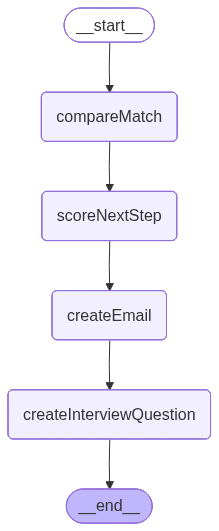

In [10]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

# **Execute First Curriculum Vitae**

In [11]:
# Extract CV PDF file
from pypdf import PdfReader
reader = PdfReader("Always Winner CV.pdf")
page = reader.pages[0]
text = page.extract_text()

In [12]:
events = graph.invoke({"messages": [("user", f"{text}")]})
messages = events["messages"]
print(messages)

[HumanMessage(content='Name  :  Always  Winner  \nPhone  Number  :  000888999  \nEmail  Address  :  alwayswinner@gmail.com \nWork  Experience  :   \nAI  Engineer,  Winner,  LLC  |  New  York  City,  NY  |  January  1,  2025  –  Present  \nJunior  AI  Engineer,  Nerwin,  LLC  |  New  York  City,  NY  |  January  1,  2024  –  December  31,  2024  \nEducation  :   \nBachelor  of  Artificial  Intelligence  |  University  of  AI  Everywhere  |  New  York  City,  NY  |  2023  \nTechnical  Skills  :   \n●  Programming  Languages:  Python  (TensorFlow,  PyTorch,  Keras,  scikit-learn,  Hugging  \nFace\n \nTransformers),\n \nJava,\n \nC++\n ●  Generative  AI:  GANs  (StyleGAN,  BigGAN),  VAEs,  Diffusion  Models,  Autoregressive  \nModels,\n \nLLMs\n \n(GPT,\n \nBERT,\n \nLLaMA),\n \nStable\n \nDiffusion\n ●  Agentic  AI  ●  Machine  Learning:  Supervised  Learning,  Unsupervised  Learning,  Transfer  Learning,  \nModel\n \nOptimization,\n \nHyperparameter\n \nTuning\n ●  Cloud  Platforms:  AWS

In [13]:
print(messages[1].content)
print("=======================")
content_dict = json.loads(messages[1].content)
mra = content_dict['minimal_requirements_analysis']
print("Minimal Requirements Analysis :", mra)
print("====================================")
pra = content_dict['preferred_requirements_analysis']
print("Preferred Requirements Analysis :", pra)
print("====================================")
strengths = content_dict['strengths']
print("Strengths :", strengths)
print("====================================")
potential_gaps = content_dict['potential_gaps']
print("Potential Gaps :", potential_gaps)

{
  "minimal_requirements_analysis": "Requirement 1: The candidate demonstrates strong capabilities across the AI lifecycle. Their skills include Python with various ML frameworks (TensorFlow, PyTorch, Keras, scikit-learn), MLOps, Data Engineering, Docker, Kubernetes, and relevant tools like MLflow, indicating proficiency from data preparation and model development to evaluation and deployment. Requirement 2: The candidate has explicit experience with LLMs (GPT, BERT, LLaMA) and Generative AI models. While specific integration into \"ERP workflows\" is not mentioned, their LLM knowledge, API Development skills, and general AI engineering background suggest a strong foundation for fine-tuning and integrating these models. Requirement 3: The candidate possesses skills in Python with Hugging Face Transformers, which is critical for NLP tools. Their broader Machine Learning and Generative AI knowledge provides a strong foundation for building smart features like recommendation engines and 

In [14]:
print(messages[2].content)
print("====================================")
content_dict = json.loads(messages[2].content)
score = content_dict['score']
print(score)

{
  "score": 9
}
9


In [15]:
print(messages[3].content)
print("====================================")
content_dict = json.loads(messages[3].content)
email = content_dict['email']
print(email)

{"email": "Hello, Always Winner\n\nThank you for applying for the AI Engineer position at AgentCore. We were very impressed with your qualifications and experience during our review process.\n\nWe would like to invite you for an interview to discuss your application further. This will be an opportunity for us to learn more about your skills and for you to learn more about AgentCore and the role.\n\nDate : 03-01-2026\n\nTime : 03:00 PM\n\nGoogle Meet interview link : https://bit.ly/agentcore-interview\n\nPlease let us know if this time works for you or if you need to reschedule. We look forward to speaking with you.\n\nThanks,\n\nHRD of AgentCore."}
Hello, Always Winner

Thank you for applying for the AI Engineer position at AgentCore. We were very impressed with your qualifications and experience during our review process.

We would like to invite you for an interview to discuss your application further. This will be an opportunity for us to learn more about your skills and for you to 

In [16]:
print(messages[4].content)
print("====================================")
content_dict = json.loads(messages[4].content)
questions = content_dict['questions']
print(questions)

{"questions": "QUESTION 1 : Your CV highlights strong expertise in Generative AI, including various LLMs like GPT, BERT, and LLaMA, as well as Diffusion Models. Can you describe a specific project where you successfully implemented or fine-tuned an LLM or Diffusion Model? What was the challenge, your approach, and the outcome?\n\nQUESTION 2 : You've listed experience with AWS, Azure, and Google Cloud Platform, along with MLOps tools like Docker, Kubernetes, and MLflow. How do you approach designing and deploying scalable AI solutions across multiple cloud environments, especially considering MLOps best practices? Can you give an example of a multi-cloud deployment challenge you faced and how you overcame it?\n\nQUESTION 3 : You've also listed 'Agentic AI' as a technical skill. Could you elaborate on your experience with Agentic AI? What types of problems have you tackled using Agentic AI approaches, and what were the key learnings or challenges?"}
QUESTION 1 : Your CV highlights strong

# **Execute Second Curriculum Vitae**

In [17]:
# Extract CV PDF file
from pypdf import PdfReader
reader = PdfReader("Sonny Wawwak CV.pdf")
page = reader.pages[0]
secondtext = page.extract_text()

In [18]:
events = graph.invoke({"messages": [("user", f"{secondtext}")]})
messages = events["messages"]
print(messages)

[HumanMessage(content='Sonny  Wawwak  \nUI/UX\n \nDesigner\n \nAddress\n \n:\n \nKonoha\n \nPhone\n \n:\n \n+62\n \n812-3456-7890\n \nEmail\n \nAddress\n \n:\n \nsonny.wawwak@email.com\n \nSkills  ●  UI  Design  (Web  &  Mobile)  ●  UX  Research  &  Analysis  ●  Wireframing  &  Prototyping  ●  Design  Systems  &  Style  Guides  ●  User  Flows  &  Journey  Mapping  ●  Usability  Testing  ●  Tools:  Figma,  Adobe  XD,  Sketch,  InVision,  Photoshop,  Illustrator  ●  HTML,  CSS  (basic  understanding)  ●  Agile  &  Scrum  Workflow  \nProfessional  Experience  UI/UX  Designer  \nPT\n \nI\n \nDon’t\n \nKnow\n \n–\n \nKonoha\n \nJan\n \n2022\n \n–\n \nPresent\n  Junior  UI/UX  Designer  \nKnow\n \nMoney\n \nOnly\n \nStudio\n \n–\n \nKonoha\n \nAug\n \n2020\n \n–\n \nDec\n \n2021\n \nEducation  \nBachelor’s  Degree  in  Visual  Communication  Design  \nDesign\n \nInstitute\n \n-\n \nKonoha\n \n2016\n \n–\n \n2020\n ', additional_kwargs={}, response_metadata={}, id='7a2bc41c-acd0-4f96-9e0d-d4e

In [19]:
print(messages[1].content)
print("=======================")
content_dict = json.loads(messages[1].content)
mra = content_dict['minimal_requirements_analysis']
print("Minimal Requirements Analysis :", mra)
print("====================================")
pra = content_dict['preferred_requirements_analysis']
print("Preferred Requirements Analysis :", pra)
print("====================================")
strengths = content_dict['strengths']
print("Strengths :", strengths)
print("====================================")
potential_gaps = content_dict['potential_gaps']
print("Potential Gaps :", potential_gaps)

{
  "minimal_requirements_analysis": "Requirement 1: There is no indication in Sonny Wawwak's CV of experience across the AI lifecycle, including data preparation, model development, evaluation, or deployment. His background is purely in UI/UX design. Requirement 2: Sonny Wawwak's CV contains no mention of skills or experience related to fine-tuning or integrating LLMs (like OpenAI and Gemini) into ERP workflows. Requirement 3: Sonny Wawwak's experience is in designing user interfaces and user experiences, not in building the underlying smart features such as recommendation engines, forecasting modules, or NLP tools from an engineering perspective.",
  "preferred_requirements_analysis": "Sonny Wawwak lacks any experience or skills related to developing and maintaining scalable cloud-based AI solutions across multi-cloud platforms (AWS, GCP, Azure). His skillset is entirely focused on design.",
  "strengths": "Sonny Wawwak possesses strong UI/UX design skills, including proficiency in d

In [20]:
print(messages[2].content)
print("====================================")
content_dict = json.loads(messages[2].content)
score = content_dict['score']
print(score)

{
  "score": 0
}
0


In [21]:
print(messages[3].content)
print("====================================")
content_dict = json.loads(messages[3].content)
email = content_dict['email']
print(email)

{"email": "Hello, Sonny Wawwak\n\nThank you for your interest in the AI Engineer position at AgentCore. We appreciate you taking the time to apply.\n\nAfter careful consideration, we regret to inform you that we will not be moving forward with your application for this role at this time.\n\nWe wish you the best in your job search.\n\nThanks,\n\nHRD of AgentCore."}
Hello, Sonny Wawwak

Thank you for your interest in the AI Engineer position at AgentCore. We appreciate you taking the time to apply.

After careful consideration, we regret to inform you that we will not be moving forward with your application for this role at this time.

We wish you the best in your job search.

Thanks,

HRD of AgentCore.


In [22]:
print(messages[4].content)
print("====================================")
content_dict = json.loads(messages[4].content)
questions = content_dict['questions']
print(questions)

{"questions": "-"}
-
